# Exercise 1
The two main goals of this exercise are:
1. Familiarizing yourself with Numpy and scipy.optimize.
2. Seeing the difference the choice of solver can make. 

### Setting: Least-squares
Let $A\in \mathbb{R}^{m\times n}$, and consider the least-squares problem
$$
\underset{x}{\text{minimize }} \frac{1}{2m}\|Ax - b\|_2^2.
$$
The solution is known in closed form:
$$
x^*=(A^\top A)^{-1}A^\top b.
$$
In this exercise, your task is to solve the least-squares problem in a number of different ways.

But first we import the necessary modules and define some utility code.

In [4]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from functools import wraps
from time import time

# Utility code for timing
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        return result, te-ts 
    return wrap

### Part 1: computational linear algebra
Compute the closed-form solution using 
1. Gaussian elimination on the normal equations, 
2. explicit inversion of $A^\top A$, and 
3. the pseudo-inverse.

Compare the computation times as as you vary $m$ and $n$ using the code below. Explain what happens when $m < n$. 

In [ ]:
@timing
def gaussian_elimination(A,b):
  raise NotImplementedError("Replace with your implementation!")

@timing
def explicit_inv(A, b):
  raise NotImplementedError("Replace with your implementation!")

@timing
def pseudo_inv(A, b):
  raise NotImplementedError("Replace with your implementation!")

# Verify that the above methods agree
rng = np.random.default_rng(seed=42)
A = rng.normal(size=(10, 3))
b = rng.normal(size=(10, 1))
assert np.allclose(gaussian_elimination(A, b)[0], explicit_inv(A, b)[0])
assert np.allclose(gaussian_elimination(A, b)[0], pseudo_inv(A, b)[0])

In [ ]:
n_exponents = 3 # Going higher than 5 might take a long time and a lot of memory
m_arr = 2 ** (10 + np.arange(n_exponents))
n_arr = 2 ** (8 + np.arange(n_exponents))
print("m_arr:\t{}\nn_arr:\t{}".format(m_arr, n_arr))


t_gaussian = np.zeros((n_exponents, n_exponents))
t_inv = np.zeros_like(t_gaussian)
t_pinv = np.zeros_like(t_gaussian)
log2_mn2 = np.zeros_like(t_gaussian) # For the complexity plots below

rng = np.random.default_rng(seed=42)

for i, m in enumerate(m_arr):
  for j, n in enumerate(n_arr):
    A = rng.normal(size=(m, n))
    b = rng.normal(size=(m, 1))
    log2_mn2[i, j] = np.log2(m) + 2 * np.log2(n)

    x_gaussian, t_gaussian[i, j] = gaussian_elimination(A, b)
    x_inv, t_inv[i, j] = explicit_inv(A, b)
    x_pinv, t_pinv[i, j] = pseudo_inv(A, b)

    if not np.allclose(x_gaussian, x_inv):
      print("Gaussian elimination and explicit inverse don't agree for m={} and n={}.".format(m, n))
    if not np.allclose(x_gaussian, x_pinv):
      print("Gaussian elimination and pseudo-inverse don't agree for m={} and n={}.".format(m, n))


Least-squares supposedly has complexity $\mathcal{O}(mn^2)$. The below plot shows $\log(mn^2)$ on the x-axis and $\log(t)$ on the y-axis, for each method. Do the methods scale according to theory? Does that mean that they're equally good in practice? For example, what are the absolute times for the largest values of $(m, n)$ that you tried? 

In [ ]:
plt.plot(log2_mn2.flatten(), np.log2(t_gaussian.flatten()), '*', label="Gaussian elimination")
plt.plot(log2_mn2.flatten(), np.log2(t_inv.flatten()), '*', label="Explicit inverse")
plt.plot(log2_mn2.flatten(), np.log2(t_pinv.flatten()), '*', label="Pseudo-inverse")
plt.xlabel("log($mn^2$)")
plt.ylabel("log(time)")
plt.legend()

### Part 1: Solution
Click the dots to see a solution

In [ ]:
@timing
def gaussian_elimination(A,b):
  x = np.linalg.solve(A.T @ A, A.T @ b)
  return x

@timing
def explicit_inv(A, b):
  AtA_inv = np.linalg.inv(A.T @ A)
  x = AtA_inv @ (A.T @ b)
  return x

@timing
def pseudo_inv(A, b):
  A_pinv = np.linalg.pinv(A)
  x = A_pinv @ b
  return x


rng = np.random.default_rng(seed=42)
A = rng.normal(size=(10, 3))
b = rng.normal(size=(10, 1))
assert np.allclose(gaussian_elimination(A, b)[0], explicit_inv(A, b)[0])
assert np.allclose(gaussian_elimination(A, b)[0], pseudo_inv(A, b)[0])

Gaussian elimination is both faster and numerically more stable than the other methods.

In [ ]:
print("On average, explicit inversion takes {:.2f} times longer than Gaussian elimination.".format(np.mean(t_inv/t_gaussian)))
print("On average, pseudo-inversion takes {:.2f} times longer than Gaussian elimination.".format(np.mean(t_pinv/t_gaussian)))

In [ ]:
# Compare absolute times for the largest (m, n)
print("Absolute times for m={} and n={}:\n\nGaussian:\t{:.2f}\nExplicit inv:\t{:.2f}\nPseudo inv:\t{:.2f}".format(
  m, n, t_gaussian.flatten()[-1], t_inv.flatten()[-1], t_pinv.flatten()[-1]))

### Part 2: scipy solvers
Add the following two solvers to your timing comparison above: 
- scipy.optimize.lsq_linear (linear least-squares with bound constraints)
- scipy.optimize.least_squares (nonlinear least-squares with bound constraints)

In [ ]:
t_lsq_linear = np.zeros_like(t_gaussian)
t_lsq_nonlinear = np.zeros_like(t_gaussian)

rng = np.random.default_rng(seed=42)

@timing
def lsq_linear(A, b):
  raise NotImplementedError("Replace with your implementation!")

@timing
def lsq_nonlinear(A, b):
  raise NotImplementedError("Replace with your implementation!")

for i, m in enumerate(m_arr):
  for j, n in enumerate(n_arr):
    A = rng.normal(size=(m, n))
    b = rng.normal(size=(m))

    _, t_lsq_linear[i, j] = lsq_linear(A, b)
    _, t_lsq_nonlinear[i, j] = lsq_nonlinear(A, b)

In [ ]:
plt.plot(log2_mn2.flatten(), np.log2(t_gaussian.flatten()), '*', label="Gaussian elimination")
plt.plot(log2_mn2.flatten(), np.log2(t_inv.flatten()), '*', label="Explicit inverse")
plt.plot(log2_mn2.flatten(), np.log2(t_pinv.flatten()), '*', label="Pseudo-inverse")
plt.plot(log2_mn2.flatten(), np.log2(t_lsq_linear.flatten()), '*', label="lsq_linear")
plt.plot(log2_mn2.flatten(), np.log2(t_lsq_nonlinear.flatten()), '*', label="least_squares")
plt.xlabel("log($mn^2$)")
plt.ylabel("log(time)")
plt.legend()

### Part 2: Solution
Click the dots to see a solution.

In [ ]:
t_lsq_linear = np.zeros_like(t_gaussian)
t_lsq_nonlinear = np.zeros_like(t_gaussian)

rng = np.random.default_rng(seed=42)

@timing
def lsq_linear(A, b):
  return opt.lsq_linear(A, b)

@timing
def lsq_nonlinear(A, b):
  return opt.least_squares(fun=lambda x: A @ x - b, x0=np.zeros(n))

for i, m in enumerate(m_arr):
  for j, n in enumerate(n_arr):
    A = rng.normal(size=(m, n))
    b = rng.normal(size=(m))

    _, t_lsq_linear[i, j] = lsq_linear(A, b)
    _, t_lsq_nonlinear[i, j] = lsq_nonlinear(A, b)

In [ ]:
plt.plot(log2_mn2.flatten(), np.log2(t_gaussian.flatten()), '*', label="Gaussian elimination")
plt.plot(log2_mn2.flatten(), np.log2(t_inv.flatten()), '*', label="Explicit inverse")
plt.plot(log2_mn2.flatten(), np.log2(t_pinv.flatten()), '*', label="Pseudo-inverse")
plt.plot(log2_mn2.flatten(), np.log2(t_lsq_linear.flatten()), '*', label="lsq_linear")
plt.plot(log2_mn2.flatten(), np.log2(t_lsq_nonlinear.flatten()), '*', label="least_squares")
plt.xlabel("log($mn^2$)")
plt.ylabel("log(time)")
plt.legend()

The takeaway from these experiments is that there is a lot to gain from picking the appropriate solver. In particular, it may be convenient to choose a general solver, but there is a price to pay in terms of the computational efficiency. Ultimately, the problem you're trying to solve determines what is a good tradeoff.

### Part 3: analytical properties
- Is the objective function continuously differentiable? To what order?
- Compute the Jacobian and Hessian. What is the Lipschitz constant? 
- What type of minimum should we expect to find?

Hint: see, for instance, [the matrix cookbook](https://ece.uwaterloo.ca/~ece602/MISC/matrixcookbook.pdf) for how to compute derivatives of matrix expressions.

### Part 3: Solution
Click the dots to see a solution.

It's a quadratic expression, hence it is infinitely differentiable (with derivatives of order higher than two being identically zero).

First, we compute the gradient:
\begin{align*}
\nabla \frac{1}{2m}\|Ax-b\|_2^2 &= \frac{1}{2m}\nabla ((x^\top A^\top A x-2(A^\top b)^\top x+b^\top b))\\
&=\frac{1}{2m}((A^\top A + A^\top A)x-2A^\top b)\\
&= \frac{1}{m}(A^\top A x-A^\top b)
\end{align*}
Note that (i) the gradient is a column vector (assuming x is), and (ii) setting the gradient to zero yields the normal equations. For a scalar function, the Jacobian is the transpose of the gradient, i.e. a row vector. 

Next, we compute the Hessian as the gradient of the Jacobian:
\begin{align*}
\nabla^2 \frac{1}{2m}\|Ax-b\|_2^2 &= \nabla \frac{1}{m}(A^\top A x-A^\top b)^\top \\
&= \frac{1}{m}A^\top A
\end{align*}

For functions that are convex and twice differentiable, the Lipschitz constant is the largest eigenvalue of the Hessian. For our least-squares problem, that means that the Lipschitz constant is
$$
L=\frac{1}{m}\lambda_\text{max}(A^\top A)=\frac{\sigma_\text{max}(A)^2}{m}=\frac{\|A\|_2^2}{m}.
$$ 

The Hessian is positive semidefinite, since for any $x\in\mathbb{R}^n$
$$
x^\top A^\top A x=(Ax)^\top (Ax)=\|Ax\|_2^2\geq 0.
$$
Thus, a solution $x^*$ is always a global minimizer (since the problem is convex) and furthermore the unique minimizer if $A$ is non-singular. Moreover, by Lemma 2.3 it is also $L$-smooth.

In [ ]:
rng = np.random.default_rng(seed=42)

lipschitz = np.zeros_like(t_gaussian)

for i, m in enumerate(m_arr):
  for j, n in enumerate(n_arr):
    A = rng.normal(size=(m, n))
    lipschitz[i, j] = np.linalg.norm(A, ord=2)**2 / m
print(lipschitz)

In [23]:
def f1(x):
    return x**2

def f2(x):
    return 2*(x-3)**2

def f3(x):
    return (f1(x) + f2(x))/2

In [24]:
x = np.linspace(-5, 10, 1000)

y1 = f1(x)
y2 = f2(x)
y3 = f3(x)


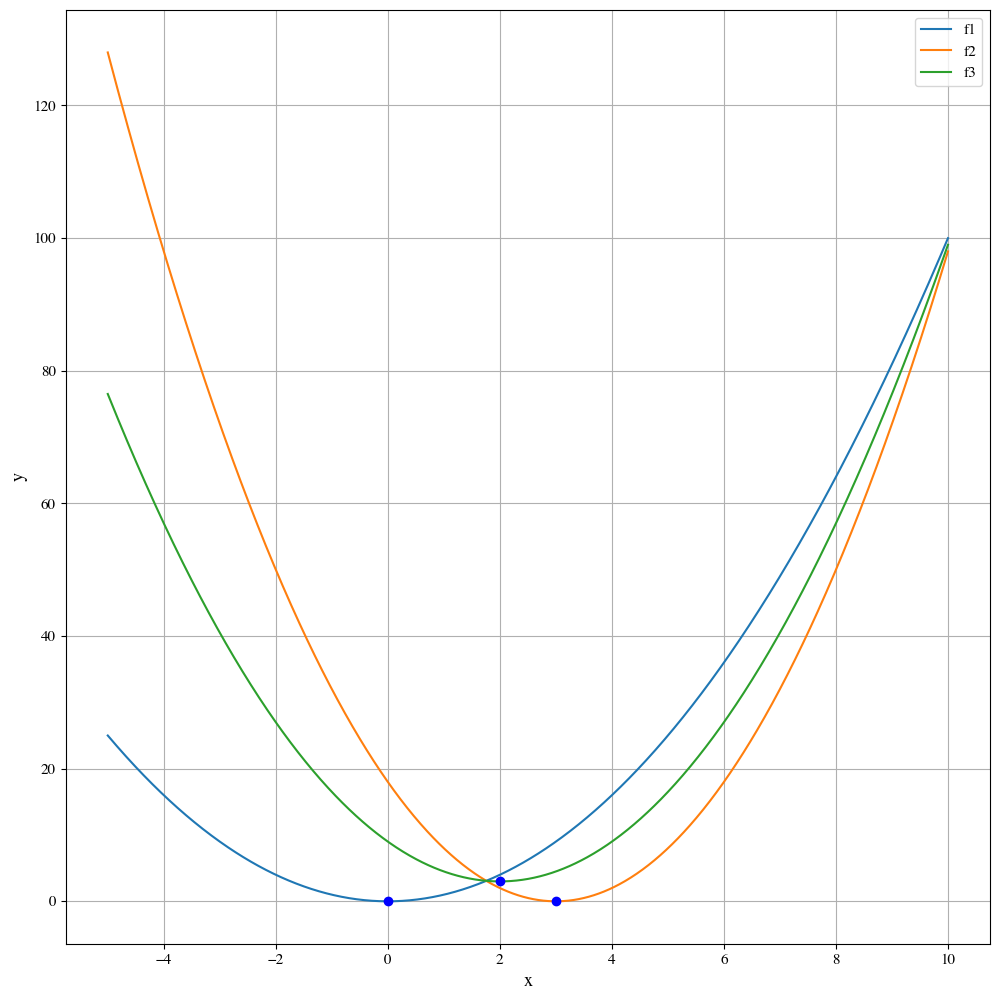

In [25]:
# plot the functions
plt.figure(figsize=(10, 10))
plt.plot(x, y1, label='f1')
plt.plot(x, y2, label='f2')
plt.plot(x, y3, label='f3')

# plot the minimum of each function
plt.plot(0, f1(0), 'bo')
plt.plot(3, f2(3), 'bo')
plt.plot(2, f3(2), 'bo')


plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()